<h1><center>PGA Tour Exploratory Data Analysis</center></h1>
This notebook outlines an exploratory data analysis for 10 years of PGA Tour data in what I thought to be relevant tour data gathered from the PGATour.com/stats website. I utilized a home-brewed web-scraping script which is outlined in another notebook in this repository. 

This EDA aims to ascertain which statistics are most vital to earning the most money over the past 10 years. I ultimately aim to create a regression model to predict yearly income given a tour player's statistics which will follow in another notebook in this repository.

We will use pandas for data organization, matplotlib and seaborn for relevant plots, as well as numpy and scipy for certain calculations.

In [8]:
# imports
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

First, we import our relevant data from an SQL database stored in this repository. The data was gathered from my webscraper of the GraphQL charts on the PGA Tour stats website--the procedure is outlined in the respective notebook.

In [10]:
import sqlite3

conn = sqlite3.connect('PGATourData_13_23.db')

cursor = conn.cursor()

query = "SELECT * FROM your_table_name"

df = pd.read_sql_query('SELECT * FROM pgatour_data', conn)

df.head()

,YEAR,PLAYER,SG:_TOTAL,SG:_TEE_TO_GREEN,SG:_OFF_THE_TEE,SG:_APPROACH_THE_GREEN,SG:_AROUND_THE_GREEN,SG:_PUTTING,DRIVING_DISTANCE,DRIVING_ACCURACY_PERCENTAGE,...,ONE_PUTT_PERCENTAGE,BIRDIE_OR_BETTER_CONVERSION_PERCENTAGE,SCORING_AVERAGE_(ACTUAL),BIRDIE_AVERAGE,PAR_3_SCORING_AVERAGE,PAR_4_SCORING_AVERAGE,PAR_5_SCORING_AVERAGE,TOP_10_FINISHES,OFFICIAL_MONEY,FEDEXCUP_REGULAR_SEASON_POINTS
0,2014,Rory McIlroy,2.266,1.992,1.367,0.602,0.022,0.274,310.5,59.93,...,41.75,36.84,69.27,4.58,3.03,3.94,4.55,12.0,8280096.0,2582.0
1,2014,Sergio Garcia,1.984,1.818,0.382,1.150,0.286,0.167,294.3,62.19,...,40.61,29.97,69.38,3.86,2.95,3.96,4.65,10.0,4939606.0,1700.0
2,2014,Jim Furyk,1.796,1.705,0.121,1.175,0.408,0.091,279.3,73.18,...,39.10,26.65,69.79,3.44,3.01,3.98,4.63,11.0,5987395.0,1851.0
3,2014,Adam Scott,1.720,1.500,0.725,0.610,0.166,0.220,303.5,61.51,...,40.44,33.89,69.49,4.24,3.10,3.97,4.48,10.0,4098588.0,1479.0
4,2014,Matt Kuchar,1.573,1.117,0.210,0.527,0.380,0.457,283.8,67.37,...,39.96,30.57,69.77,3.82,3.04,3.97,4.65,11.0,4695515.0,1921.0


In [12]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1527 entries, 0 to 1526
Data columns (total 28 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   YEAR                                     1527 non-null   int64  
 1   PLAYER                                   1527 non-null   object 
 2   SG:_TOTAL                                1527 non-null   float64
 3   SG:_TEE_TO_GREEN                         1527 non-null   float64
 4   SG:_OFF_THE_TEE                          1527 non-null   float64
 5   SG:_APPROACH_THE_GREEN                   1527 non-null   float64
 6   SG:_AROUND_THE_GREEN                     1527 non-null   float64
 7   SG:_PUTTING                              1527 non-null   float64
 8   DRIVING_DISTANCE                         1527 non-null   float64
 9   DRIVING_ACCURACY_PERCENTAGE              1527 non-null   float64
 10  CLUB_HEAD_SPEED                          1527 no

Given the formatting in the web scraping notebook, there are no null entries or formatting issues with the data, so we may proceed.

The ultimate goal is to utilize regression to estimate a tour player's income utilizing their various statistics. The goal of this EDA is to determine the most important features as well as how we may structure our data to build a regression model.

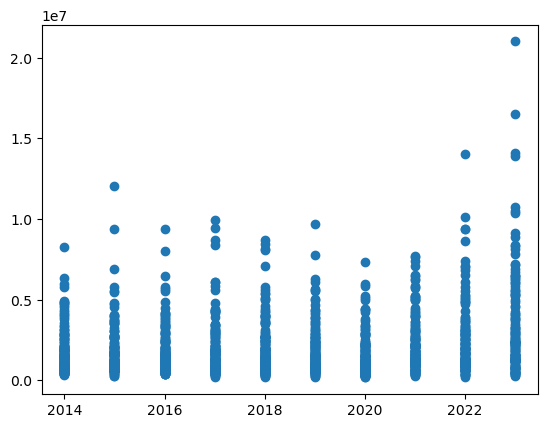

In [14]:
fig, ax = plt.subplots()
ax.scatter(df["YEAR"], df["OFFICIAL_MONEY"])
plt.show()

In creating a scatter plot over the past 10 years, we can see that there is a significant increase in top earners over the past two PGA Tour seasons. Let's look into this further.

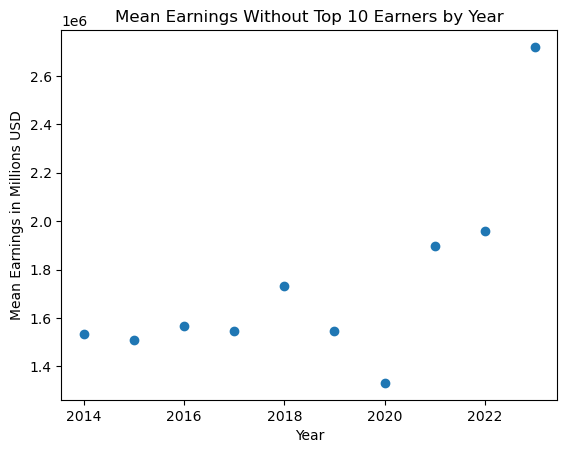

In [48]:
def remove_top_10_and_mean(group):
    group = group.sort_values(by='OFFICIAL_MONEY', ascending=False).iloc[10:]  # Remove top 10 earners
    return group['OFFICIAL_MONEY'].mean()

# Apply the function to each year group
mean_earnings_without_top_10 = df.groupby('YEAR').apply(remove_top_10_and_mean).reset_index(name='MEAN_EARNINGS')

fig, ax = plt.subplots()
ax.scatter(mean_earnings_without_top_10["YEAR"], mean_earnings_without_top_10["MEAN_EARNINGS"])
ax.set_xlabel('Year')
ax.set_ylabel('Mean Earnings in Millions USD')
ax.set_title('Mean Earnings Without Top 10 Earners by Year')
plt.show()

I removed the top 10 earners each year to get a more accurate sense of the average earnings among more typical PGA Tour players -- not looking at the absolute best. Even with these players removed, players in 2023 made, on average, around 700 thousand dollars more than the average in 2022. And, in 2021 and 2022 tour players made on average around 200 thousand dollars more than the previous 7 years.

With the creation of the Saudi-backed LIV Golf in 2021, the PGA Tour has been under constant pressure to increase purse amounts for their tournaments to ensure PGA players' loyalties. This accounts for this discrepency and must be considered when structuring any type of regression.

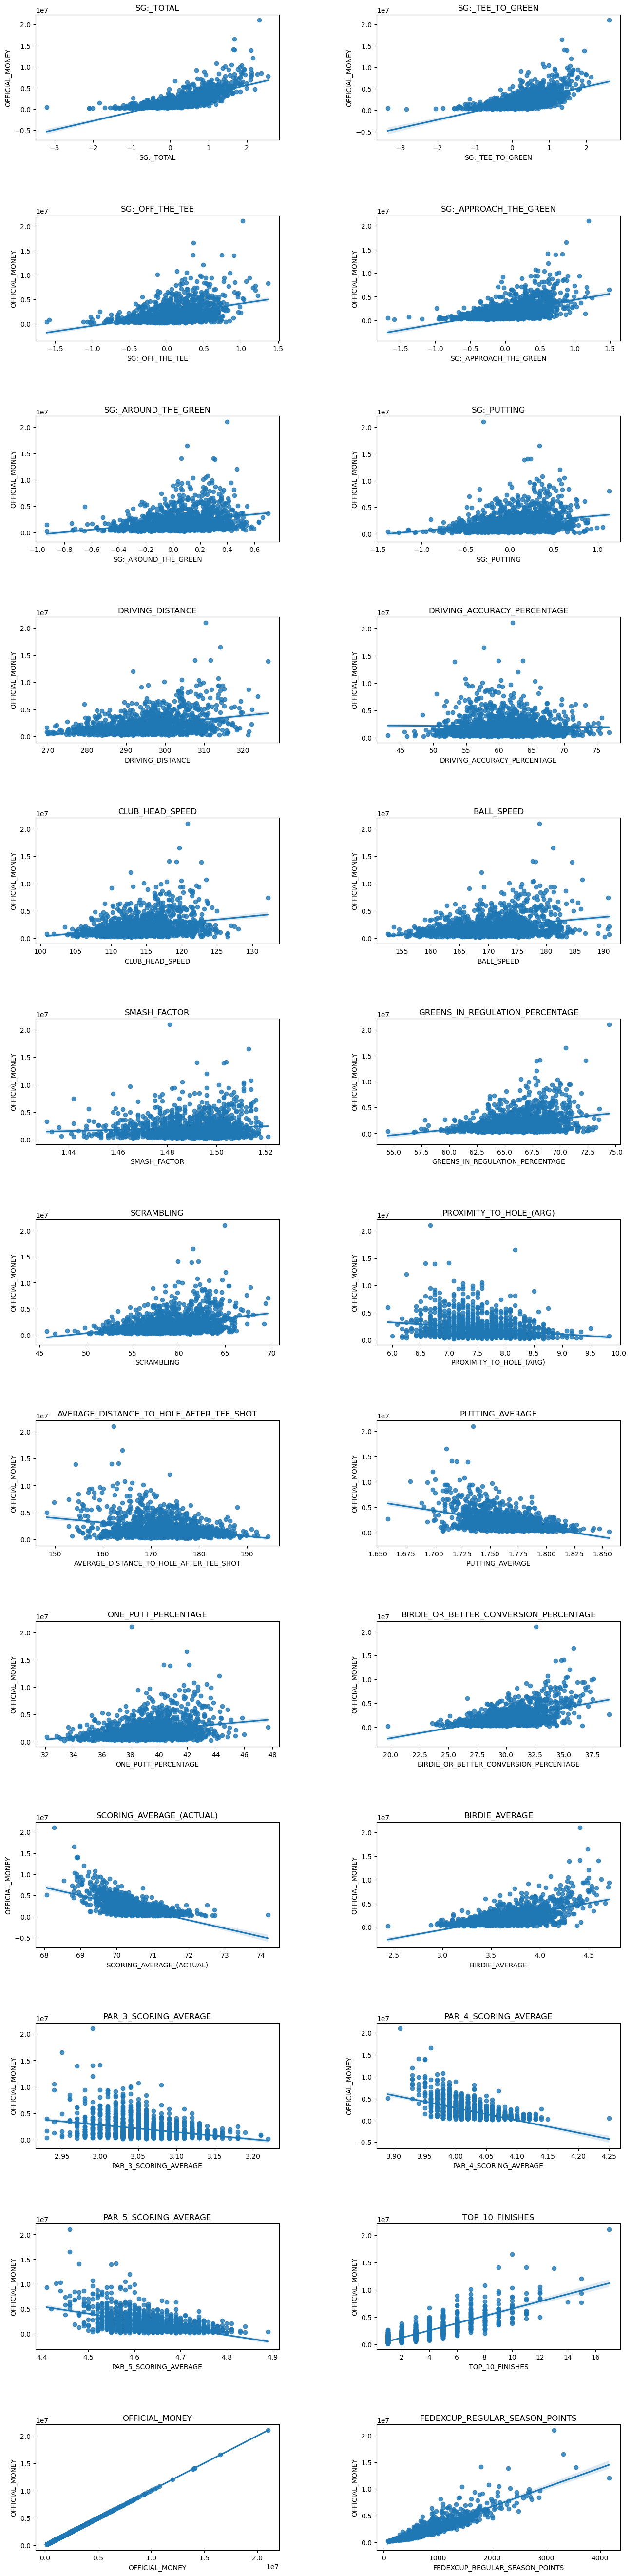

In [42]:
float_columns = df.select_dtypes(include='float').columns

num_plots = len(float_columns)
cols_per_row = 2  
num_rows = -(-num_plots // cols_per_row)

# Create subplots
f, ax = plt.subplots(num_rows, 2, figsize=(15, num_rows * 5))

row = 0
col = 0

for i, column in enumerate(float_columns):
    g = sns.regplot(x=df[column], y="OFFICIAL_MONEY", ax=ax[row][col], data=df)
    g.set(title=column)
    col += 1
    if col == 2:
        col = 0
        row += 1
        
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.6)

## TO BE CONTINUED